# 💊 Adverse Drug Event Severity Classifier

**Author:** Jason Finkle  
**Project:** Healthcare NLP / Pharmacovigilance Classification  

This project predicts the severity of adverse drug events using data from the FDA Adverse Event Reporting System (FAERS). By analyzing drug characteristics, patient demographics, and MedDRA-coded reaction terms, we build machine learning models to classify whether an adverse event resulted in serious outcomes (hospitalization, disability, life-threatening conditions, or death).

**Business Value:** Pharmaceutical companies spend millions annually on pharmacovigilance. Automated severity classification can help:
- Prioritize safety reports for medical review
- Identify high-risk drug-event combinations
- Support regulatory compliance (15-day serious AE reporting requirement)
- Enable early signal detection for drug safety

---

## 1. Setup and Configuration

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
import warnings
import re
import os
from datetime import datetime
from collections import Counter
warnings.filterwarnings('ignore')

# NLP libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_curve, auc,
                             roc_auc_score)

# Model Interpretability
import shap

# Scipy for sparse matrix operations
from scipy.sparse import hstack, csr_matrix

# Set random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Create directories
os.makedirs('figures', exist_ok=True)
os.makedirs('data', exist_ok=True)

# Define color palette
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'accent': '#F18F01',
    'success': '#28A745',
    'danger': '#DC3545',
    'warning': '#FFC107',
    'dark': '#343A40',
    'purple': '#6F42C1',
    'teal': '#20C997'
}

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("✅ Libraries loaded successfully")
print("   - NLP: TF-IDF, CountVectorizer")
print("   - ML: Logistic Regression, Random Forest, Gradient Boosting, Naive Bayes")
print("   - Interpretability: SHAP")

✅ Libraries loaded successfully
   - NLP: TF-IDF, CountVectorizer
   - ML: Logistic Regression, Random Forest, Gradient Boosting, Naive Bayes
   - Interpretability: SHAP


## 2. Data Collection from FDA FAERS API

We'll use the openFDA API to fetch adverse event reports. The API provides:
- **Drug information**: Brand names, generic names, routes of administration
- **Patient demographics**: Age, sex, weight
- **Reaction terms**: MedDRA-coded adverse event descriptions
- **Seriousness indicators**: Death, hospitalization, life-threatening, disability

Our target variable will be **severity level** based on seriousness indicators.

In [2]:
def fetch_faers_data(search_term=None, max_records=10000, limit_per_call=100):
    """
    Fetch adverse event reports from openFDA FAERS API

    Parameters:
    -----------
    search_term : str, optional
        Drug name or condition to search for
    max_records : int
        Maximum number of records to fetch
    limit_per_call : int
        Records per API call (max 100)

    Returns:
    --------
    list : List of adverse event records
    """

    base_url = "https://api.fda.gov/drug/event.json"
    all_records = []
    skip = 0

    print(f"📥 Fetching FAERS data...")
    if search_term:
        print(f"   Search term: {search_term}")

    while len(all_records) < max_records:
        params = {
            "limit": min(limit_per_call, max_records - len(all_records)),
            "skip": skip
        }

        # Add search term if provided
        if search_term:
            params["search"] = search_term

        try:
            response = requests.get(base_url, params=params, timeout=30)

            if response.status_code == 404:
                print(f"   ⚠️ No more records found")
                break

            response.raise_for_status()
            data = response.json()

            results = data.get("results", [])
            if not results:
                break

            all_records.extend(results)
            skip += limit_per_call

            # Progress update
            if len(all_records) % 1000 == 0:
                print(f"   Retrieved {len(all_records):,} records...")

            # Rate limiting (40 requests/min without API key)
            time.sleep(1.5)

        except requests.exceptions.RequestException as e:
            print(f"   ⚠️ API error: {e}")
            time.sleep(5)
            continue

    print(f"   ✅ Retrieved {len(all_records):,} adverse event records")
    return all_records


# Check if data already exists
DATA_FILE = "data/faers_adverse_events.csv"

if os.path.exists(DATA_FILE):
    print(f"📂 Loading cached data from {DATA_FILE}")
    df_raw = pd.read_csv(DATA_FILE)
    print(f"   Loaded {len(df_raw):,} records")
else:
    print("🌐 Fetching data from openFDA API...")
    print("   (This may take 10-15 minutes)\n")

    # Fetch diverse set of adverse events
    # We'll fetch recent serious events to get a good mix
    all_records = fetch_faers_data(max_records=15000)

🌐 Fetching data from openFDA API...
   (This may take 10-15 minutes)

📥 Fetching FAERS data...
   Retrieved 1,000 records...
   Retrieved 2,000 records...
   Retrieved 3,000 records...
   Retrieved 4,000 records...
   Retrieved 5,000 records...
   Retrieved 6,000 records...
   Retrieved 7,000 records...
   Retrieved 8,000 records...
   Retrieved 9,000 records...
   Retrieved 10,000 records...
   Retrieved 11,000 records...
   Retrieved 12,000 records...
   Retrieved 13,000 records...
   Retrieved 14,000 records...
   Retrieved 15,000 records...
   ✅ Retrieved 15,000 adverse event records


In [3]:
def extract_event_features(record):
    """
    Extract relevant features from a FAERS record

    Parameters:
    -----------
    record : dict
        Raw record from API

    Returns:
    --------
    dict : Extracted features
    """

    # Report metadata
    safety_report_id = record.get("safetyreportid", "")
    receive_date = record.get("receivedate", "")

    # Seriousness indicators (our target)
    serious = record.get("serious", "")
    seriousness_death = record.get("seriousnessdeath", "0")
    seriousness_hosp = record.get("seriousnesshospitalization", "0")
    seriousness_lifethreat = record.get("seriousnesslifethreatening", "0")
    seriousness_disable = record.get("seriousnessdisabling", "0")
    seriousness_congential = record.get("seriousnesscongenitalanomali", "0")
    seriousness_other = record.get("seriousnessother", "0")

    # Patient info
    patient = record.get("patient", {})
    patient_age = patient.get("patientonsetage", "")
    patient_age_unit = patient.get("patientonsetageunit", "")
    patient_sex = patient.get("patientsex", "")
    patient_weight = patient.get("patientweight", "")

    # Drugs involved
    drugs = patient.get("drug", [])
    drug_names = []
    drug_indications = []
    drug_routes = []
    suspect_drugs = []

    for drug in drugs:
        med_name = drug.get("medicinalproduct", "")
        if med_name:
            drug_names.append(med_name.upper())

        # Get openfda standardized names
        openfda = drug.get("openfda", {})
        generic_names = openfda.get("generic_name", [])
        brand_names = openfda.get("brand_name", [])
        drug_names.extend([n.upper() for n in generic_names])
        drug_names.extend([n.upper() for n in brand_names])

        indication = drug.get("drugindication", "")
        if indication:
            drug_indications.append(indication.upper())

        route = drug.get("drugadministrationroute", "")
        if route:
            drug_routes.append(route)

        # Check if suspect drug
        if drug.get("drugcharacterization", "") == "1":
            suspect_drugs.append(med_name.upper() if med_name else "")

    # Reactions (MedDRA terms) - this is our main text feature
    reactions = patient.get("reaction", [])
    reaction_terms = []
    reaction_outcomes = []

    for reaction in reactions:
        term = reaction.get("reactionmeddrapt", "")
        if term:
            reaction_terms.append(term.upper())
        outcome = reaction.get("reactionoutcome", "")
        if outcome:
            reaction_outcomes.append(outcome)

    # Reporter info
    primary_source = record.get("primarysource", {})
    reporter_qualification = primary_source.get("qualification", "")
    reporter_country = record.get("occurcountry", "")

    return {
        'safety_report_id': safety_report_id,
        'receive_date': receive_date,
        'serious': serious,
        'seriousness_death': seriousness_death,
        'seriousness_hospitalization': seriousness_hosp,
        'seriousness_lifethreatening': seriousness_lifethreat,
        'seriousness_disabling': seriousness_disable,
        'seriousness_congenital': seriousness_congential,
        'seriousness_other': seriousness_other,
        'patient_age': patient_age,
        'patient_age_unit': patient_age_unit,
        'patient_sex': patient_sex,
        'patient_weight': patient_weight,
        'drug_names': ' | '.join(list(set(drug_names))),
        'drug_indications': ' | '.join(list(set(drug_indications))),
        'drug_routes': ' | '.join(list(set(drug_routes))),
        'suspect_drugs': ' | '.join(list(set(suspect_drugs))),
        'num_drugs': len(drugs),
        'num_suspect_drugs': len(suspect_drugs),
        'reaction_terms': ' | '.join(reaction_terms),
        'reaction_text': ' '.join(reaction_terms),  # For NLP
        'num_reactions': len(reaction_terms),
        'reaction_outcomes': ' | '.join(reaction_outcomes),
        'reporter_qualification': reporter_qualification,
        'reporter_country': reporter_country
    }


# Process records if not cached
if not os.path.exists(DATA_FILE):
    print("\n🔄 Processing adverse event records...")

    processed_records = []
    for i, record in enumerate(all_records):
        try:
            features = extract_event_features(record)
            processed_records.append(features)
        except Exception as e:
            continue

        if (i + 1) % 2000 == 0:
            print(f"   Processed {i + 1:,} records...")

    # Create DataFrame
    df_raw = pd.DataFrame(processed_records)

    # Save to CSV
    df_raw.to_csv(DATA_FILE, index=False)
    print(f"\n✅ Saved {len(df_raw):,} records to {DATA_FILE}")

print(f"\n📊 Dataset shape: {df_raw.shape}")
df_raw.head()


🔄 Processing adverse event records...
   Processed 2,000 records...
   Processed 4,000 records...
   Processed 6,000 records...
   Processed 8,000 records...
   Processed 10,000 records...
   Processed 12,000 records...
   Processed 14,000 records...

✅ Saved 15,000 records to data/faers_adverse_events.csv

📊 Dataset shape: (15000, 25)


,safety_report_id,receive_date,serious,seriousness_death,seriousness_hospitalization,seriousness_lifethreatening,seriousness_disabling,seriousness_congenital,seriousness_other,patient_age,...,drug_routes,suspect_drugs,num_drugs,num_suspect_drugs,reaction_terms,reaction_text,num_reactions,reaction_outcomes,reporter_qualification,reporter_country
0,5801206-7,20080707,1,1,0,0,0,0,0,26,...,041,DURAGESIC-100,1,1,DRUG ADMINISTRATION ERROR | OVERDOSE,DRUG ADMINISTRATION ERROR OVERDOSE,2,,3,
1,10003300,20140306,1,0,0,0,1,0,0,77,...,042,BONIVA,1,1,VOMITING | DIARRHOEA | ARTHRALGIA | HEADACHE,VOMITING DIARRHOEA ARTHRALGIA HEADACHE,4,,5,
2,10003301,20140228,1,0,0,0,0,0,1,,...,,IBUPROFEN,1,1,DYSPEPSIA | RENAL IMPAIRMENT,DYSPEPSIA RENAL IMPAIRMENT,2,,5,
3,10003302,20140312,2,0,0,0,0,0,0,,...,,LYRICA,1,1,DRUG INEFFECTIVE,DRUG INEFFECTIVE,1,6,5,US
4,10003304,20140312,2,0,0,0,0,0,0,,...,,LORTAB | TRAMADOL HYDROCHLORIDE | TALWIN | IOD...,9,9,DRUG HYPERSENSITIVITY,DRUG HYPERSENSITIVITY,1,6,1,US


## 3. Data Cleaning and Target Engineering

In [4]:
# Create working copy
df = df_raw.copy()

# Convert seriousness columns to numeric
seriousness_cols = ['seriousness_death', 'seriousness_hospitalization',
                    'seriousness_lifethreatening', 'seriousness_disabling',
                    'seriousness_congenital', 'seriousness_other']

for col in seriousness_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

# Create severity target variable (hierarchical)
# Level 4: Death (most severe)
# Level 3: Life-threatening
# Level 2: Hospitalization or Disabling
# Level 1: Other serious
# Level 0: Non-serious

def assign_severity(row):
    if row['seriousness_death'] == 1:
        return 4  # Death
    elif row['seriousness_lifethreatening'] == 1:
        return 3  # Life-threatening
    elif row['seriousness_hospitalization'] == 1 or row['seriousness_disabling'] == 1:
        return 2  # Hospitalization/Disabling
    elif row['seriousness_other'] == 1 or row['seriousness_congenital'] == 1:
        return 1  # Other serious
    else:
        return 0  # Non-serious

df['severity'] = df.apply(assign_severity, axis=1)

# Create severity labels
severity_labels = {
    0: 'Non-Serious',
    1: 'Other Serious',
    2: 'Hospitalization/Disability',
    3: 'Life-Threatening',
    4: 'Death'
}
df['severity_label'] = df['severity'].map(severity_labels)

# For binary classification (simpler, more balanced)
# Severe (death, life-threatening, hospitalization) vs Non-severe
df['is_severe'] = (df['severity'] >= 2).astype(int)

print("📊 TARGET VARIABLE DISTRIBUTION")
print("=" * 60)
print("\nSeverity Levels (Multi-class):")
print(df['severity_label'].value_counts().sort_index())
print(f"\nBinary Classification:")
print(f"   Severe (hospitalization/life-threatening/death): {df['is_severe'].sum():,} ({df['is_severe'].mean()*100:.1f}%)")
print(f"   Non-severe: {(1-df['is_severe']).sum():,} ({(1-df['is_severe'].mean())*100:.1f}%)")

📊 TARGET VARIABLE DISTRIBUTION

Severity Levels (Multi-class):
severity_label
Death                         1146
Hospitalization/Disability    2753
Life-Threatening               282
Non-Serious                   6377
Other Serious                 4442
Name: count, dtype: int64

Binary Classification:
   Severe (hospitalization/life-threatening/death): 4,181 (27.9%)
   Non-severe: 10,819 (72.1%)


In [5]:
# Clean patient demographics
# Standardize age to years
def convert_age_to_years(row):
    age = pd.to_numeric(row['patient_age'], errors='coerce')
    unit = str(row['patient_age_unit'])

    if pd.isna(age):
        return np.nan

    # Unit codes: 800=decade, 801=year, 802=month, 803=week, 804=day, 805=hour
    if unit == '800':
        return age * 10
    elif unit == '801':
        return age
    elif unit == '802':
        return age / 12
    elif unit == '803':
        return age / 52
    elif unit == '804':
        return age / 365
    elif unit == '805':
        return age / (365 * 24)
    else:
        return age  # Assume years if unknown

df['age_years'] = df.apply(convert_age_to_years, axis=1)

# Filter reasonable ages (0-120)
df.loc[df['age_years'] > 120, 'age_years'] = np.nan
df.loc[df['age_years'] < 0, 'age_years'] = np.nan

# Clean weight (convert to kg, filter outliers)
df['weight_kg'] = pd.to_numeric(df['patient_weight'], errors='coerce')
df.loc[df['weight_kg'] > 300, 'weight_kg'] = np.nan
df.loc[df['weight_kg'] < 1, 'weight_kg'] = np.nan

# Clean sex (1=Male, 2=Female, 0=Unknown)
df['sex'] = pd.to_numeric(df['patient_sex'], errors='coerce').fillna(0).astype(int)
sex_labels = {0: 'Unknown', 1: 'Male', 2: 'Female'}
df['sex_label'] = df['sex'].map(sex_labels)

# Reporter qualification
# 1=Physician, 2=Pharmacist, 3=Other health professional, 4=Lawyer, 5=Consumer
df['reporter_qual'] = pd.to_numeric(df['reporter_qualification'], errors='coerce').fillna(5).astype(int)
df['is_health_professional'] = (df['reporter_qual'].isin([1, 2, 3])).astype(int)

# Clean reaction text
df['reaction_text'] = df['reaction_text'].fillna('').str.strip()

# Filter out records with no reaction text
df = df[df['reaction_text'].str.len() > 0].copy()

print("✅ Data cleaning complete")
print(f"\nCleaned dataset shape: {df.shape}")
print(f"\nPatient Age (years):")
print(df['age_years'].describe())
print(f"\nSex distribution:")
print(df['sex_label'].value_counts())

✅ Data cleaning complete

Cleaned dataset shape: (15000, 34)

Patient Age (years):
count    9599.000000
mean       56.773632
std        19.594548
min         0.000000
25%        46.000000
50%        60.000000
75%        71.000000
max       103.000000
Name: age_years, dtype: float64

Sex distribution:
sex_label
Female     8520
Male       4834
Unknown    1646
Name: count, dtype: int64


## 4. Exploratory Data Analysis

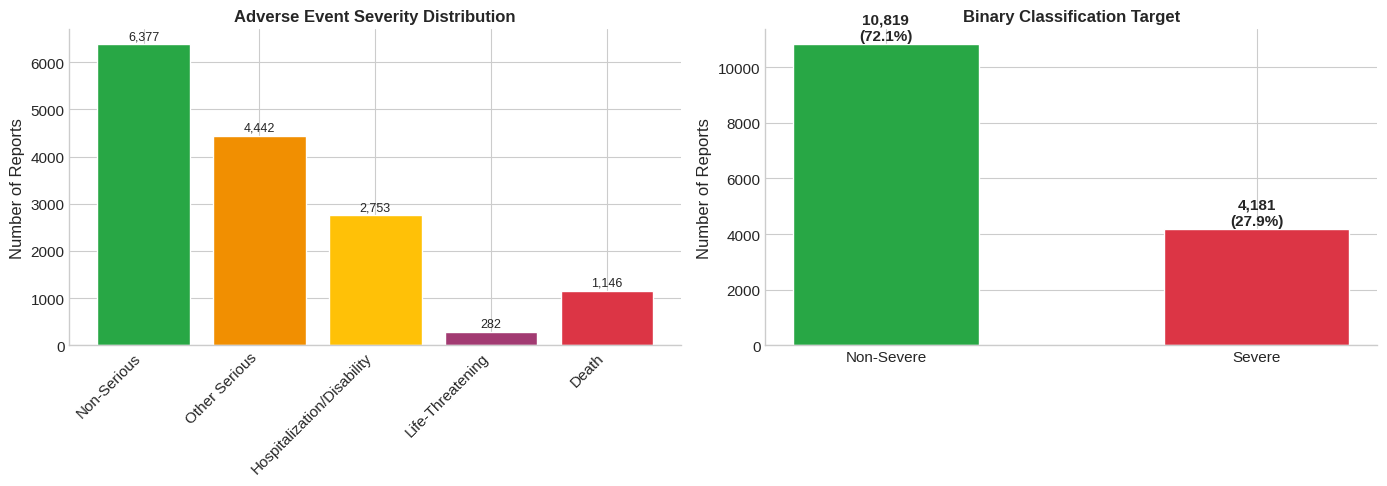

✅ Saved: figures/01_severity_distribution.png


In [6]:
# Figure 1: Severity Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Multi-class severity
ax1 = axes[0]
severity_counts = df['severity_label'].value_counts().reindex(
    ['Non-Serious', 'Other Serious', 'Hospitalization/Disability', 'Life-Threatening', 'Death']
)
colors_severity = [COLORS['success'], COLORS['accent'], COLORS['warning'],
                   COLORS['secondary'], COLORS['danger']]

bars = ax1.bar(range(len(severity_counts)), severity_counts.values,
               color=colors_severity, edgecolor='white')
ax1.set_xticks(range(len(severity_counts)))
ax1.set_xticklabels(severity_counts.index, rotation=45, ha='right')
ax1.set_ylabel('Number of Reports')
ax1.set_title('Adverse Event Severity Distribution', fontsize=12, fontweight='bold')

for bar, val in zip(bars, severity_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{val:,}', ha='center', va='bottom', fontsize=9)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Right: Binary classification
ax2 = axes[1]
binary_counts = df['is_severe'].value_counts()
labels = ['Non-Severe', 'Severe']
colors_binary = [COLORS['success'], COLORS['danger']]

bars = ax2.bar(labels, [binary_counts.get(0, 0), binary_counts.get(1, 0)],
               color=colors_binary, width=0.5, edgecolor='white')

for bar, val in zip(bars, [binary_counts.get(0, 0), binary_counts.get(1, 0)]):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{val:,}\n({val/len(df)*100:.1f}%)', ha='center', va='bottom',
             fontsize=11, fontweight='bold')

ax2.set_ylabel('Number of Reports')
ax2.set_title('Binary Classification Target', fontsize=12, fontweight='bold')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/01_severity_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/01_severity_distribution.png")

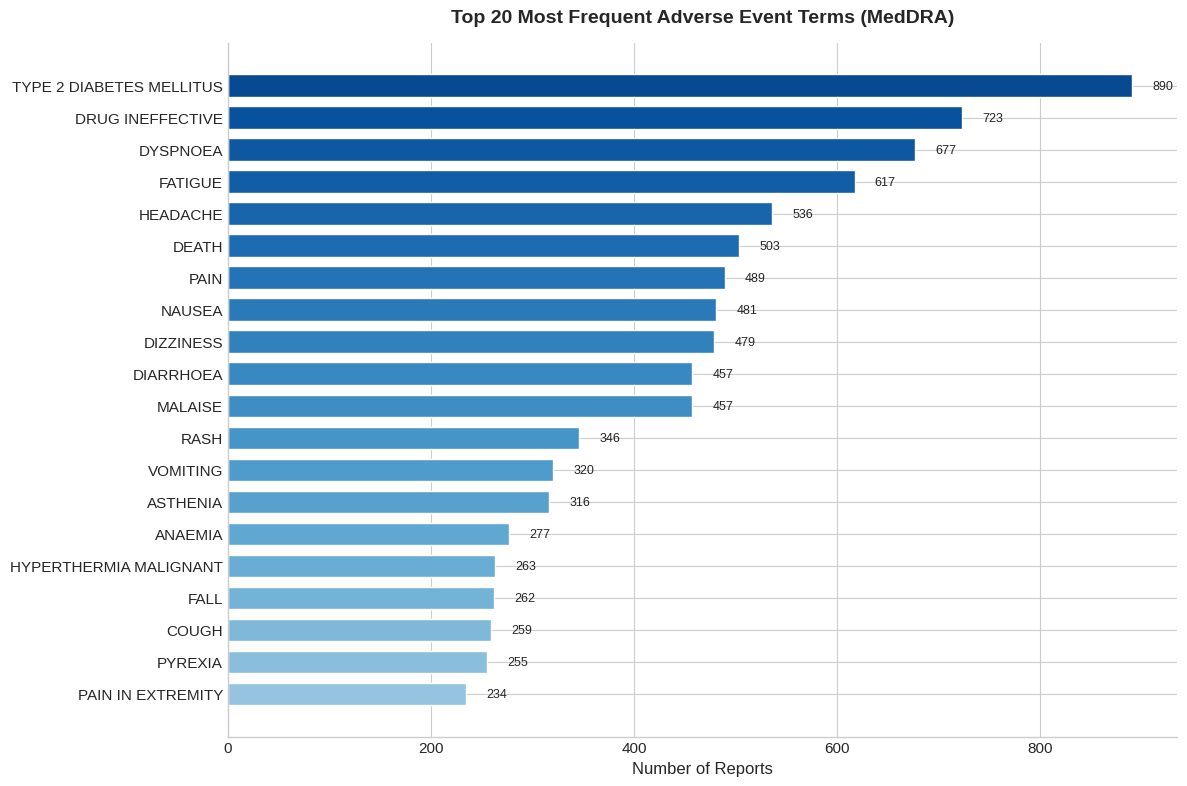

✅ Saved: figures/02_top_reactions.png


In [7]:
# Figure 2: Top Reaction Terms
# Parse all reaction terms
all_reactions = []
for terms in df['reaction_terms'].dropna():
    all_reactions.extend([t.strip() for t in str(terms).split('|') if t.strip()])

reaction_counts = Counter(all_reactions)
top_reactions = pd.DataFrame(reaction_counts.most_common(20),
                              columns=['Reaction', 'Count'])

fig, ax = plt.subplots(figsize=(12, 8))

colors_react = plt.cm.Blues(np.linspace(0.4, 0.9, len(top_reactions)))
bars = ax.barh(top_reactions['Reaction'][::-1], top_reactions['Count'][::-1],
               color=colors_react, edgecolor='white', height=0.7)

for bar, val in zip(bars, top_reactions['Count'][::-1]):
    ax.text(val + 20, bar.get_y() + bar.get_height()/2,
            f'{val:,}', va='center', fontsize=9)

ax.set_xlabel('Number of Reports')
ax.set_title('Top 20 Most Frequent Adverse Event Terms (MedDRA)',
             fontsize=14, fontweight='bold', pad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/02_top_reactions.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/02_top_reactions.png")

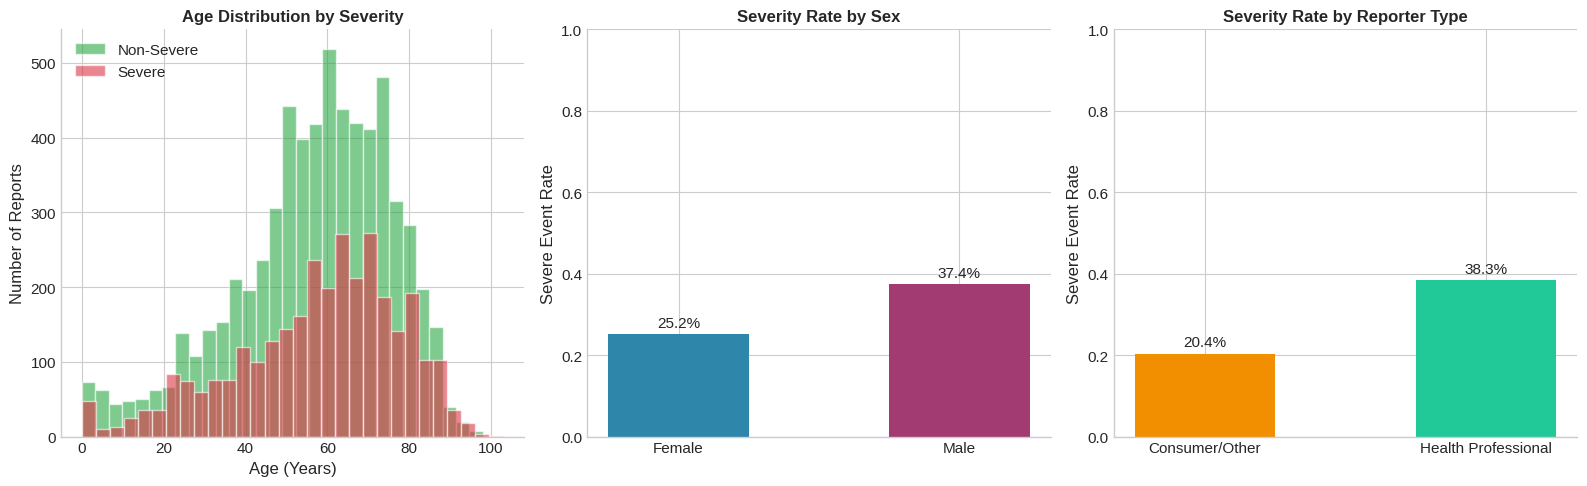

✅ Saved: figures/03_demographics_analysis.png


In [8]:
# Figure 3: Severity by Patient Demographics
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Age distribution by severity
ax1 = axes[0]
for severity, color, label in [(0, COLORS['success'], 'Non-Severe'),
                                (1, COLORS['danger'], 'Severe')]:
    data = df[df['is_severe'] == severity]['age_years'].dropna()
    ax1.hist(data, bins=30, alpha=0.6, color=color, label=label, edgecolor='white')

ax1.set_xlabel('Age (Years)')
ax1.set_ylabel('Number of Reports')
ax1.set_title('Age Distribution by Severity', fontsize=12, fontweight='bold')
ax1.legend()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Severity rate by sex
ax2 = axes[1]
sex_severity = df.groupby('sex_label')['is_severe'].mean().drop('Unknown', errors='ignore')
bars = ax2.bar(sex_severity.index, sex_severity.values,
               color=[COLORS['primary'], COLORS['secondary']], width=0.5)

for bar, val in zip(bars, sex_severity.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.1%}', ha='center', va='bottom', fontsize=11)

ax2.set_ylabel('Severe Event Rate')
ax2.set_title('Severity Rate by Sex', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Severity by reporter type
ax3 = axes[2]
reporter_severity = df.groupby('is_health_professional')['is_severe'].mean()
labels = ['Consumer/Other', 'Health Professional']
bars = ax3.bar(labels, reporter_severity.values,
               color=[COLORS['accent'], COLORS['teal']], width=0.5)

for bar, val in zip(bars, reporter_severity.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.1%}', ha='center', va='bottom', fontsize=11)

ax3.set_ylabel('Severe Event Rate')
ax3.set_title('Severity Rate by Reporter Type', fontsize=12, fontweight='bold')
ax3.set_ylim(0, 1)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/03_demographics_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/03_demographics_analysis.png")

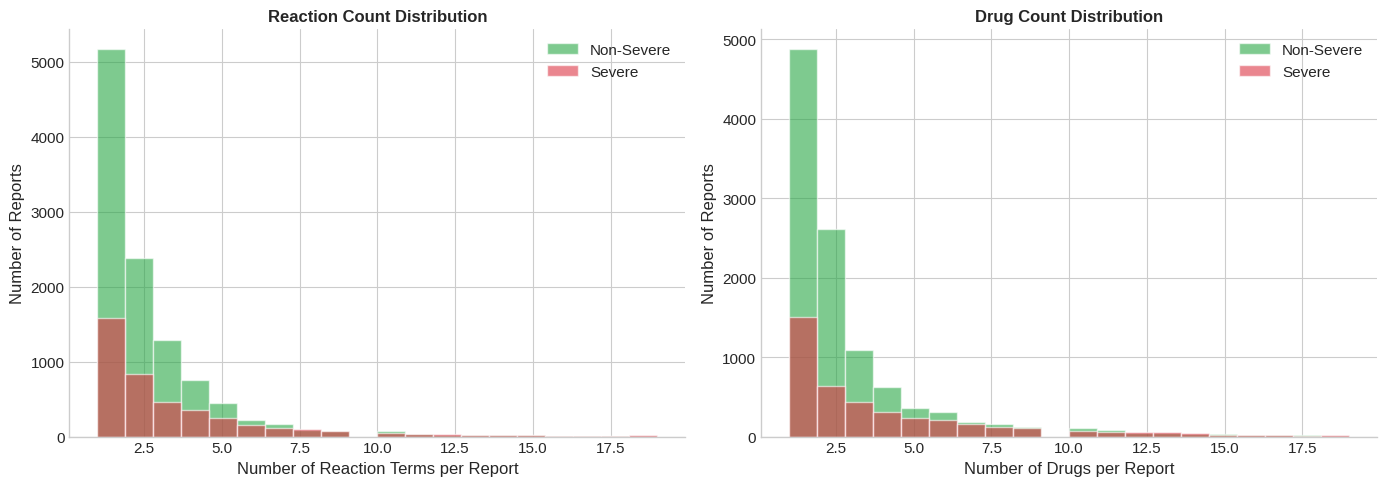

✅ Saved: figures/04_count_analysis.png


In [9]:
# Figure 4: Number of reactions/drugs vs severity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Reactions per report by severity
ax1 = axes[0]
for severity, color, label in [(0, COLORS['success'], 'Non-Severe'),
                                (1, COLORS['danger'], 'Severe')]:
    data = df[df['is_severe'] == severity]['num_reactions']
    data = data[data < 20]  # Filter outliers
    ax1.hist(data, bins=20, alpha=0.6, color=color, label=label, edgecolor='white')

ax1.set_xlabel('Number of Reaction Terms per Report')
ax1.set_ylabel('Number of Reports')
ax1.set_title('Reaction Count Distribution', fontsize=12, fontweight='bold')
ax1.legend()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Drugs per report by severity
ax2 = axes[1]
for severity, color, label in [(0, COLORS['success'], 'Non-Severe'),
                                (1, COLORS['danger'], 'Severe')]:
    data = df[df['is_severe'] == severity]['num_drugs']
    data = data[data < 20]  # Filter outliers
    ax2.hist(data, bins=20, alpha=0.6, color=color, label=label, edgecolor='white')

ax2.set_xlabel('Number of Drugs per Report')
ax2.set_ylabel('Number of Reports')
ax2.set_title('Drug Count Distribution', fontsize=12, fontweight='bold')
ax2.legend()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/04_count_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/04_count_analysis.png")

## 5. NLP Feature Engineering

We'll create text features from:
1. **Reaction terms** (MedDRA coded terms) - TF-IDF vectorization
2. **Drug indications** - TF-IDF vectorization
3. **Structured features** - Patient demographics, counts, reporter type

In [10]:
# Prepare text preprocessing
def preprocess_text(text):
    """Clean and normalize text for NLP"""
    if pd.isna(text):
        return ''

    text = str(text).upper()
    # Remove special characters but keep spaces
    text = re.sub(r'[^A-Z\s]', ' ', text)
    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Preprocess reaction text
df['reaction_text_clean'] = df['reaction_text'].apply(preprocess_text)
df['indication_text_clean'] = df['drug_indications'].apply(preprocess_text)

# Combine reaction and indication text
df['combined_text'] = df['reaction_text_clean'] + ' ' + df['indication_text_clean']

print("📝 TEXT FEATURE EXAMPLES")
print("=" * 60)
print("\nSample reaction terms:")
for i, text in enumerate(df['reaction_text_clean'].head(3)):
    print(f"   {i+1}. {text[:100]}...")

print("\n✅ Text preprocessing complete")

📝 TEXT FEATURE EXAMPLES

Sample reaction terms:
   1. DRUG ADMINISTRATION ERROR OVERDOSE...
   2. VOMITING DIARRHOEA ARTHRALGIA HEADACHE...
   3. DYSPEPSIA RENAL IMPAIRMENT...

✅ Text preprocessing complete


In [11]:
# Create TF-IDF features from reaction text
print("🔤 Creating TF-IDF features...")

# TF-IDF for reaction terms (main text feature)
tfidf_reactions = TfidfVectorizer(
    max_features=500,         # Top 500 terms
    min_df=5,                 # Appear in at least 5 documents
    max_df=0.95,              # Not in more than 95% of documents
    ngram_range=(1, 2),       # Unigrams and bigrams
    stop_words='english'
)

X_reaction_tfidf = tfidf_reactions.fit_transform(df['reaction_text_clean'])
print(f"   Reaction TF-IDF shape: {X_reaction_tfidf.shape}")

# Get feature names for interpretation
reaction_features = tfidf_reactions.get_feature_names_out()
print(f"   Sample features: {list(reaction_features[:10])}")

# TF-IDF for drug indications (secondary text feature)
tfidf_indications = TfidfVectorizer(
    max_features=200,
    min_df=5,
    max_df=0.95,
    ngram_range=(1, 2),
    stop_words='english'
)

X_indication_tfidf = tfidf_indications.fit_transform(df['indication_text_clean'])
print(f"   Indication TF-IDF shape: {X_indication_tfidf.shape}")

print("\n✅ TF-IDF vectorization complete")

🔤 Creating TF-IDF features...
   Reaction TF-IDF shape: (15000, 500)
   Sample features: ['abasia', 'abdominal', 'abdominal discomfort', 'abdominal distension', 'abdominal pain', 'abnormal', 'abortion', 'abscess', 'abuse', 'accident']
   Indication TF-IDF shape: (15000, 200)

✅ TF-IDF vectorization complete


In [12]:
# Create structured features
print("📊 Creating structured features...")

# Numeric features
df['age_years_clean'] = df['age_years'].fillna(df['age_years'].median())
df['weight_kg_clean'] = df['weight_kg'].fillna(df['weight_kg'].median())
df['num_reactions_clean'] = df['num_reactions'].clip(upper=20)  # Cap outliers
df['num_drugs_clean'] = df['num_drugs'].clip(upper=20)

structured_features = ['age_years_clean', 'weight_kg_clean', 'num_reactions_clean',
                       'num_drugs_clean', 'num_suspect_drugs', 'is_health_professional']

# One-hot encode sex
sex_dummies = pd.get_dummies(df['sex'], prefix='sex')
df = pd.concat([df, sex_dummies], axis=1)
structured_features.extend(sex_dummies.columns.tolist())

# Create structured feature matrix
X_structured = df[structured_features].values

# Scale structured features
scaler = StandardScaler()
X_structured_scaled = scaler.fit_transform(X_structured)
X_structured_sparse = csr_matrix(X_structured_scaled)

print(f"   Structured features shape: {X_structured_sparse.shape}")
print(f"   Features: {structured_features}")

print("\n✅ Structured features complete")

📊 Creating structured features...
   Structured features shape: (15000, 9)
   Features: ['age_years_clean', 'weight_kg_clean', 'num_reactions_clean', 'num_drugs_clean', 'num_suspect_drugs', 'is_health_professional', 'sex_0', 'sex_1', 'sex_2']

✅ Structured features complete


In [13]:
# Combine all features
print("🔗 Combining feature matrices...")

X_combined = hstack([X_reaction_tfidf, X_indication_tfidf, X_structured_sparse])

# Create feature names list for interpretation
all_feature_names = (list(reaction_features) +
                     list(tfidf_indications.get_feature_names_out()) +
                     structured_features)

# Target variable
y = df['is_severe'].values

print(f"\n📊 FINAL FEATURE MATRIX")
print("=" * 60)
print(f"Total samples: {X_combined.shape[0]:,}")
print(f"Total features: {X_combined.shape[1]:,}")
print(f"   - Reaction TF-IDF: {X_reaction_tfidf.shape[1]}")
print(f"   - Indication TF-IDF: {X_indication_tfidf.shape[1]}")
print(f"   - Structured: {X_structured_sparse.shape[1]}")
print(f"\nTarget distribution:")
print(f"   Severe: {y.sum():,} ({y.mean()*100:.1f}%)")
print(f"   Non-severe: {(1-y).sum():,} ({(1-y.mean())*100:.1f}%)")

🔗 Combining feature matrices...

📊 FINAL FEATURE MATRIX
Total samples: 15,000
Total features: 709
   - Reaction TF-IDF: 500
   - Indication TF-IDF: 200
   - Structured: 9

Target distribution:
   Severe: 4,181 (27.9%)
   Non-severe: 10,819 (72.1%)


## 6. Model Training and Evaluation

In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("📊 TRAIN/TEST SPLIT")
print("=" * 60)
print(f"Training samples: {X_train.shape[0]:,}")
print(f"Test samples: {X_test.shape[0]:,}")
print(f"Training severe rate: {y_train.mean()*100:.1f}%")
print(f"Test severe rate: {y_test.mean()*100:.1f}%")

📊 TRAIN/TEST SPLIT
Training samples: 12,000
Test samples: 3,000
Training severe rate: 27.9%
Test severe rate: 27.9%


In [15]:
# Define models
# Note: Using class_weight='balanced' to handle class imbalance
models = {
    'Logistic Regression': LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=1000,
        class_weight='balanced'
    ),
    'Naive Bayes': MultinomialNB(),  # Good baseline for text classification
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE
    )
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Store results
results = {}

print("🤖 TRAINING MODELS WITH 5-FOLD CROSS-VALIDATION")
print("=" * 60)

for name, model in models.items():
    print(f"\n📈 Training {name}...")

    # For Naive Bayes, need non-negative data
    if name == 'Naive Bayes':
        # Use only TF-IDF features for NB
        X_tr_nb = hstack([X_reaction_tfidf, X_indication_tfidf])
        X_train_nb, X_test_nb, _, _ = train_test_split(
            X_tr_nb, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
        )
        X_tr, X_te = X_train_nb, X_test_nb
    else:
        X_tr, X_te = X_train, X_test

    # Cross-validation
    try:
        scores = cross_val_score(model, X_tr, y_train, cv=cv, scoring='roc_auc')
        print(f"   CV AUC: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")
    except Exception as e:
        print(f"   CV skipped: {e}")
        scores = [0]

    # Fit on full training set
    model.fit(X_tr, y_train)

    # Predictions
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1]

    # Calculate metrics
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'fpr': fpr,
        'tpr': tpr,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc,
        'cv_mean': np.mean(scores),
        'cv_std': np.std(scores)
    }

    print(f"   Test AUC: {roc_auc:.4f}")
    print(f"   Accuracy: {results[name]['accuracy']:.4f}")
    print(f"   F1 Score: {results[name]['f1']:.4f}")

print("\n" + "=" * 60)
print("✅ All models trained!")

🤖 TRAINING MODELS WITH 5-FOLD CROSS-VALIDATION

📈 Training Logistic Regression...
   CV AUC: 0.8922 (+/- 0.0101)
   Test AUC: 0.8830
   Accuracy: 0.8103
   F1 Score: 0.6962

📈 Training Naive Bayes...
   CV AUC: 0.8630 (+/- 0.0077)
   Test AUC: 0.8516
   Accuracy: 0.8077
   F1 Score: 0.6535

📈 Training Random Forest...
   CV AUC: 0.8874 (+/- 0.0142)
   Test AUC: 0.8833
   Accuracy: 0.8270
   F1 Score: 0.6606

📈 Training Gradient Boosting...
   CV AUC: 0.8714 (+/- 0.0160)
   Test AUC: 0.8595
   Accuracy: 0.8173
   F1 Score: 0.5719

✅ All models trained!


In [16]:
# Create metrics summary
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV AUC': [f"{results[m]['cv_mean']:.4f} ± {results[m]['cv_std']:.4f}" for m in results],
    'Test AUC': [results[m]['auc'] for m in results],
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1 Score': [results[m]['f1'] for m in results]
}).round(4)

metrics_df = metrics_df.sort_values('Test AUC', ascending=False).reset_index(drop=True)

print("\n📊 MODEL PERFORMANCE SUMMARY")
print("=" * 80)
print(metrics_df.to_string(index=False))

# Save
metrics_df.to_csv('model_metrics_summary.csv', index=False)
print("\n✅ Saved: model_metrics_summary.csv")


📊 MODEL PERFORMANCE SUMMARY
              Model          CV AUC  Test AUC  Accuracy  Precision  Recall  F1 Score
      Random Forest 0.8874 ± 0.0071    0.8833    0.8270     0.7287  0.6041    0.6606
Logistic Regression 0.8922 ± 0.0050    0.8830    0.8103     0.6287  0.7799    0.6962
  Gradient Boosting 0.8714 ± 0.0080    0.8595    0.8173     0.8243  0.4378    0.5719
        Naive Bayes 0.8630 ± 0.0039    0.8516    0.8077     0.6562  0.6507    0.6535

✅ Saved: model_metrics_summary.csv


## 7. Model Visualizations

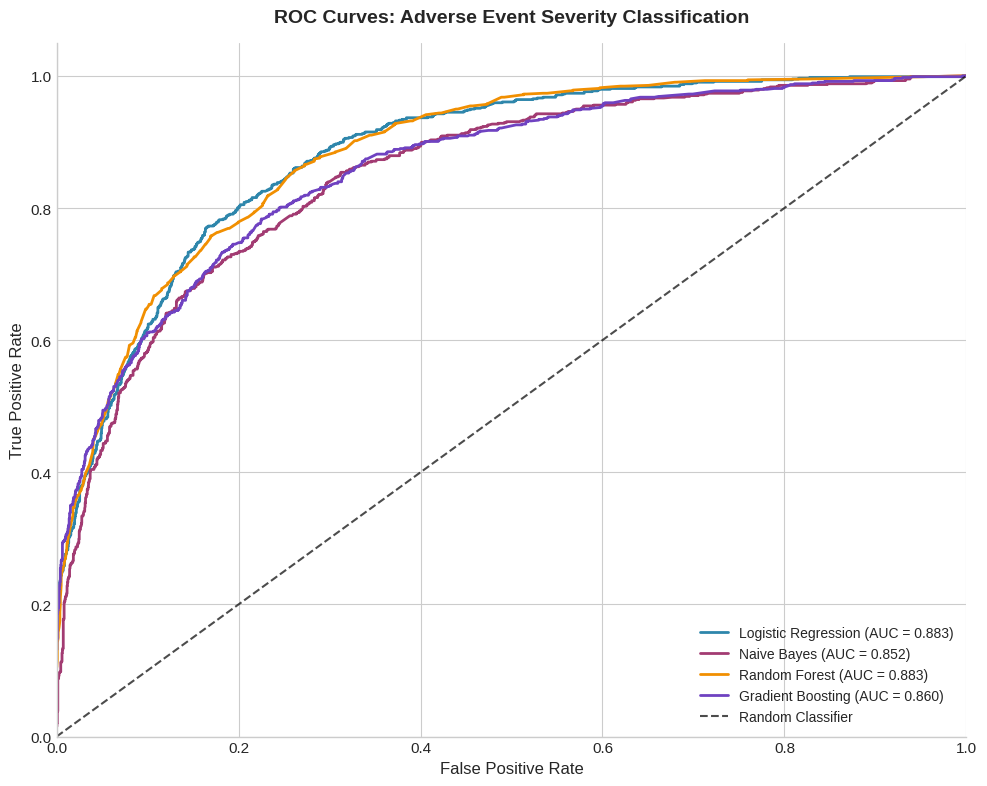

✅ Saved: figures/05_roc_curves.png


In [17]:
# Figure 5: ROC Curves
fig, ax = plt.subplots(figsize=(10, 8))

colors_models = [COLORS['primary'], COLORS['secondary'], COLORS['accent'], COLORS['purple']]

for (name, res), color in zip(results.items(), colors_models):
    ax.plot(res['fpr'], res['tpr'], color=color, lw=2,
            label=f"{name} (AUC = {res['auc']:.3f})")

ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.7, label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves: Adverse Event Severity Classification',
             fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='lower right', fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/05_roc_curves.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/05_roc_curves.png")

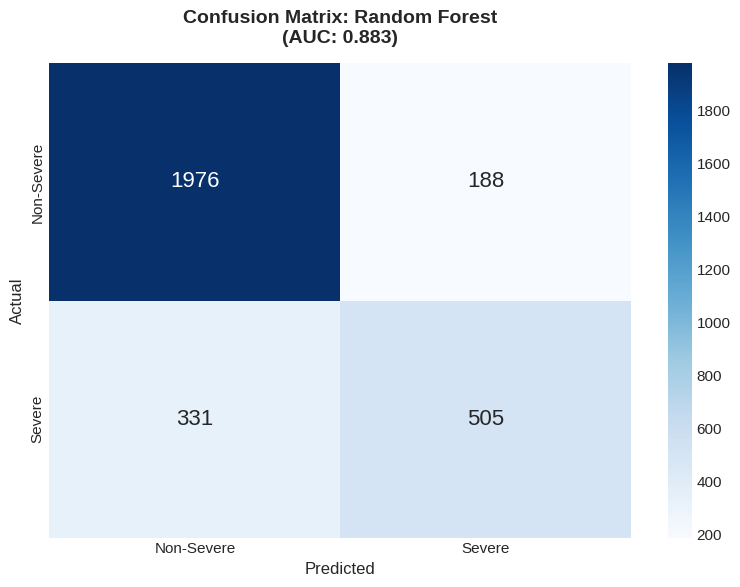

✅ Saved: figures/06_confusion_matrix.png


In [18]:
# Figure 6: Confusion Matrix (Best Model)
best_model_name = metrics_df.iloc[0]['Model']
best_results = results[best_model_name]

cm = confusion_matrix(y_test, best_results['y_pred'])

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Severe', 'Severe'],
            yticklabels=['Non-Severe', 'Severe'],
            annot_kws={'size': 16}, ax=ax)

ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title(f'Confusion Matrix: {best_model_name}\n(AUC: {best_results["auc"]:.3f})',
             fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('figures/06_confusion_matrix.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/06_confusion_matrix.png")

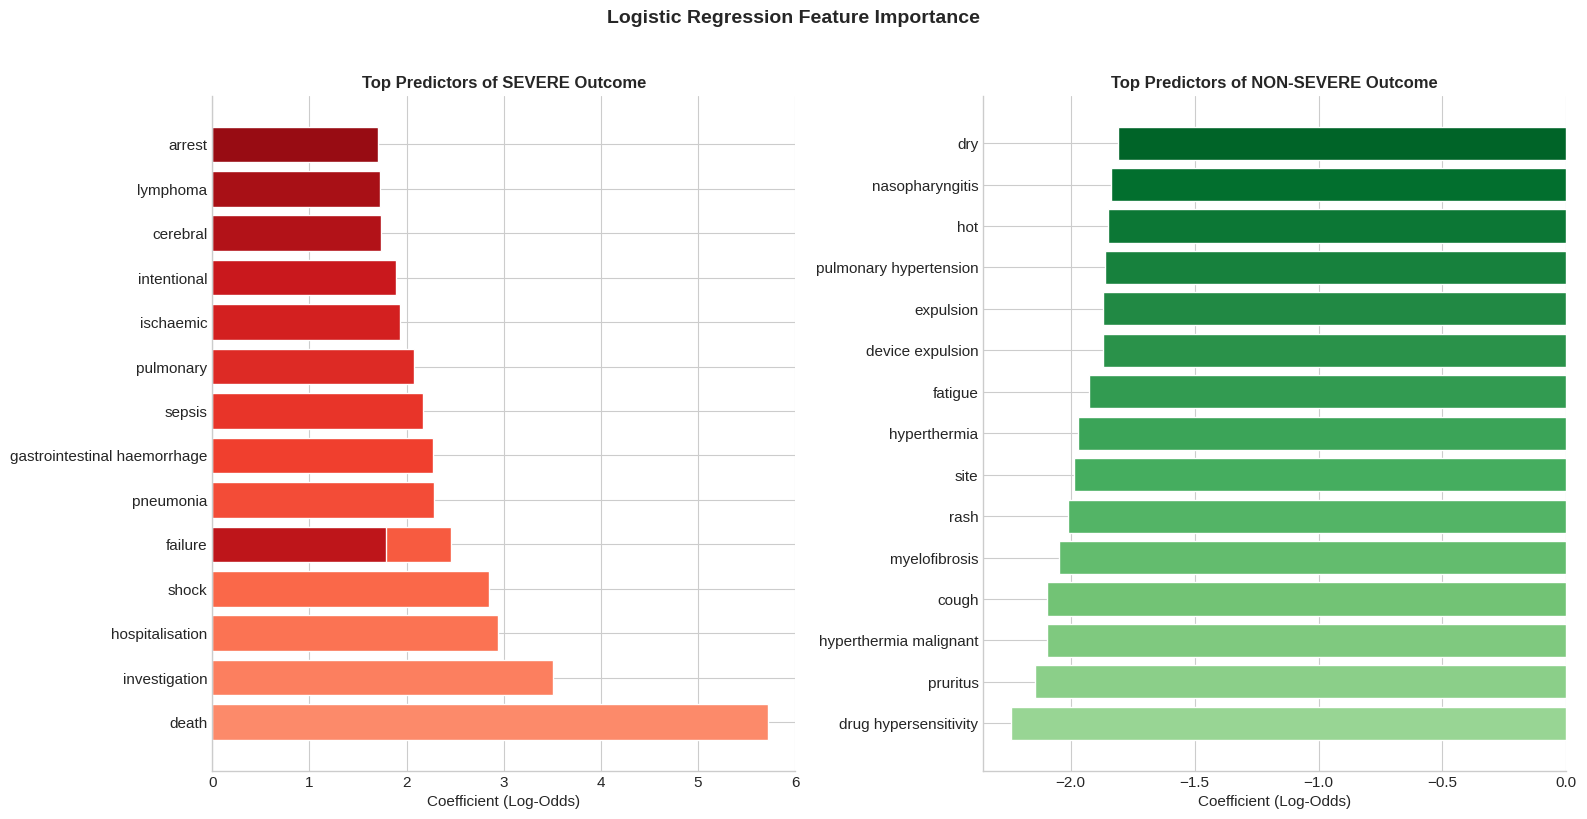

✅ Saved: figures/07_feature_coefficients.png


In [19]:
# Figure 7: Top Predictive Features (Logistic Regression coefficients)
lr_model = results['Logistic Regression']['model']
coefficients = lr_model.coef_[0]

# Get top features
feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})

# Top positive (predict severe) and negative (predict non-severe)
top_positive = feature_importance.nlargest(15, 'Coefficient')
top_negative = feature_importance.nsmallest(15, 'Coefficient')

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Predictors of Severe
ax1 = axes[0]
colors_pos = plt.cm.Reds(np.linspace(0.4, 0.9, len(top_positive)))
bars = ax1.barh(top_positive['Feature'], top_positive['Coefficient'],
                color=colors_pos, edgecolor='white')
ax1.set_xlabel('Coefficient (Log-Odds)', fontsize=11)
ax1.set_title('Top Predictors of SEVERE Outcome', fontsize=12, fontweight='bold')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Predictors of Non-Severe
ax2 = axes[1]
colors_neg = plt.cm.Greens(np.linspace(0.4, 0.9, len(top_negative)))
bars = ax2.barh(top_negative['Feature'], top_negative['Coefficient'],
                color=colors_neg, edgecolor='white')
ax2.set_xlabel('Coefficient (Log-Odds)', fontsize=11)
ax2.set_title('Top Predictors of NON-SEVERE Outcome', fontsize=12, fontweight='bold')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.suptitle('Logistic Regression Feature Importance', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figures/07_feature_coefficients.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/07_feature_coefficients.png")

## 8. SHAP Model Interpretability

In [20]:
# SHAP analysis using Logistic Regression (linear model)
print("🔍 Computing SHAP values...")
print("   (Using a sample for computational efficiency)\n")

# Sample for SHAP (computational efficiency)
sample_size = min(1000, X_test.shape[0])
sample_idx = np.random.choice(X_test.shape[0], sample_size, replace=False)
X_test_sample = X_test[sample_idx].toarray()  # Convert to dense for SHAP

# Use Linear explainer for Logistic Regression
lr_model = results['Logistic Regression']['model']
explainer = shap.LinearExplainer(lr_model, X_train.toarray()[:1000], feature_names=all_feature_names)
shap_values = explainer.shap_values(X_test_sample)

print("✅ SHAP values computed!")
print(f"   Shape: {shap_values.shape}")

🔍 Computing SHAP values...
   (Using a sample for computational efficiency)

✅ SHAP values computed!
   Shape: (1000, 709)


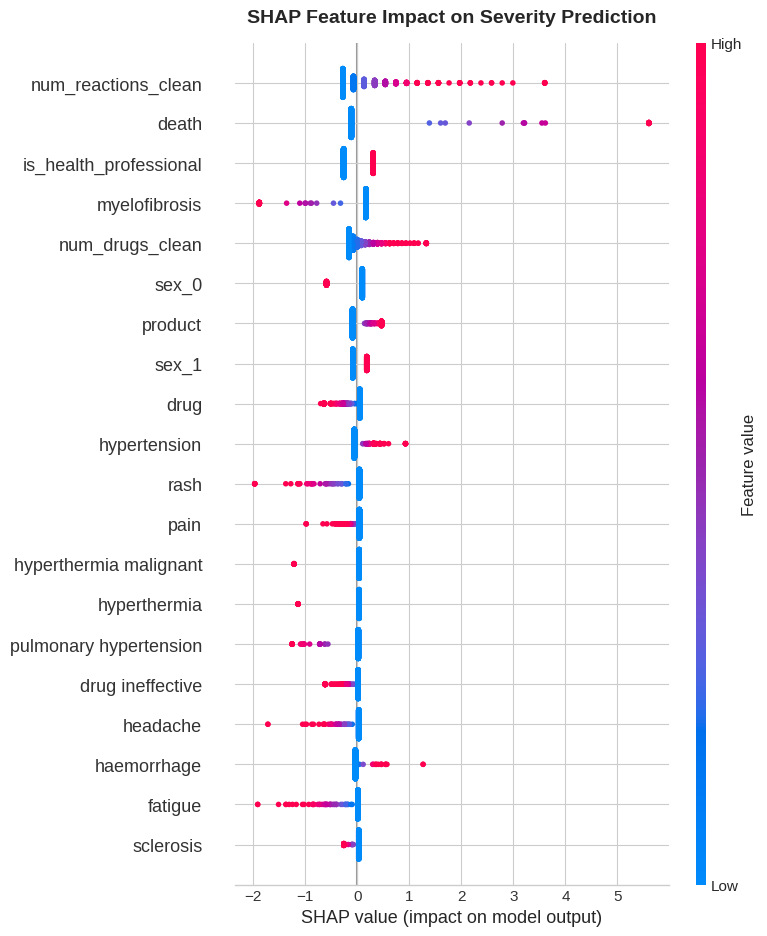

✅ Saved: figures/08_shap_summary.png

📊 SHAP INTERPRETATION:
   • Red points = high feature values
   • Blue points = low feature values
   • Right of center = increases severity prediction
   • Left of center = decreases severity prediction


In [21]:
# Figure 8: SHAP Summary Plot
fig, ax = plt.subplots(figsize=(12, 10))

shap.summary_plot(
    shap_values,
    X_test_sample,
    feature_names=all_feature_names,
    plot_type="dot",
    show=False,
    max_display=20
)

plt.title('SHAP Feature Impact on Severity Prediction', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('figures/08_shap_summary.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/08_shap_summary.png")

print("\n📊 SHAP INTERPRETATION:")
print("   • Red points = high feature values")
print("   • Blue points = low feature values")
print("   • Right of center = increases severity prediction")
print("   • Left of center = decreases severity prediction")

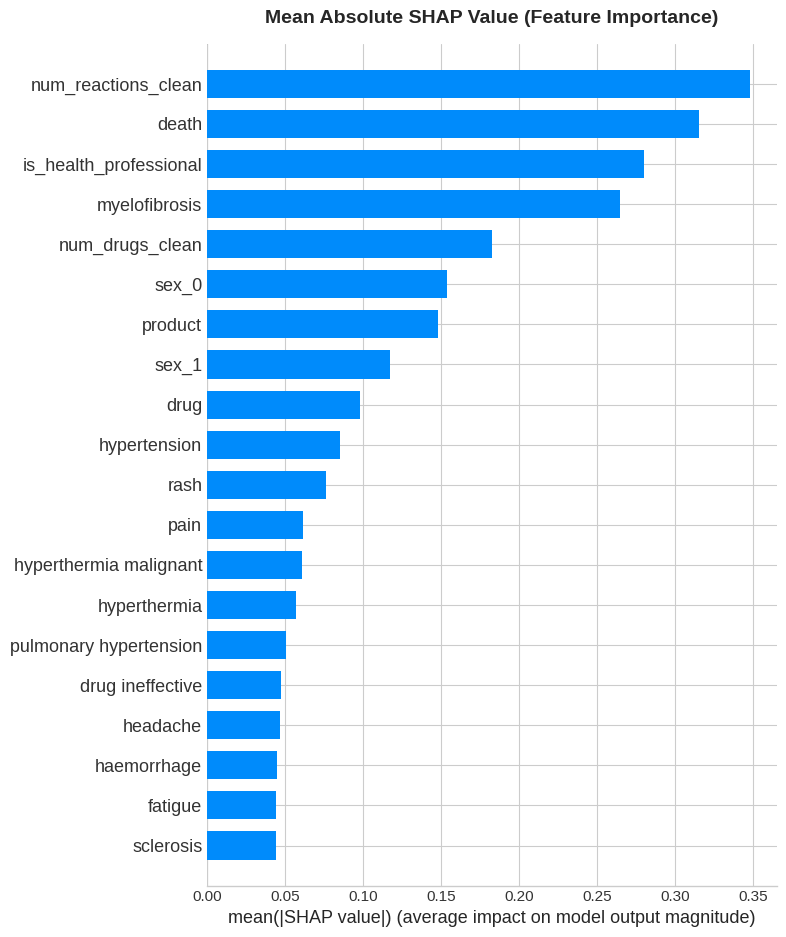

✅ Saved: figures/09_shap_importance.png


In [22]:
# Figure 9: SHAP Bar Plot
fig, ax = plt.subplots(figsize=(10, 8))

shap.summary_plot(
    shap_values,
    X_test_sample,
    feature_names=all_feature_names,
    plot_type="bar",
    show=False,
    max_display=20
)

plt.title('Mean Absolute SHAP Value (Feature Importance)', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('figures/09_shap_importance.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: figures/09_shap_importance.png")

## 9. Example Predictions

In [23]:
# Demonstrate predictions on sample cases
print("🔮 SAMPLE PREDICTIONS")
print("=" * 70)

# Get best model
best_model = results[best_model_name]['model']

# Show some examples
test_indices = np.random.choice(len(y_test), 5, replace=False)

for i, idx in enumerate(test_indices):
    actual = y_test[idx]
    if best_model_name == 'Naive Bayes':
        pred_prob = results[best_model_name]['y_prob'][idx]
    else:
        pred_prob = best_model.predict_proba(X_test[idx])[0, 1]

    # Get original data
    original_idx = df.index[int(len(df) * 0.8) + idx]  # Approximate test index

    print(f"\nCase {i+1}:")
    print(f"   Predicted Severity Probability: {pred_prob:.2%}")
    print(f"   Prediction: {'SEVERE' if pred_prob > 0.5 else 'Non-Severe'}")
    print(f"   Actual: {'SEVERE' if actual == 1 else 'Non-Severe'}")
    print(f"   Correct: {'✅' if (pred_prob > 0.5) == actual else '❌'}")

🔮 SAMPLE PREDICTIONS

Case 1:
   Predicted Severity Probability: 5.00%
   Prediction: Non-Severe
   Actual: Non-Severe
   Correct: ✅

Case 2:
   Predicted Severity Probability: 73.00%
   Prediction: SEVERE
   Actual: Non-Severe
   Correct: ❌

Case 3:
   Predicted Severity Probability: 13.83%
   Prediction: Non-Severe
   Actual: Non-Severe
   Correct: ✅

Case 4:
   Predicted Severity Probability: 35.00%
   Prediction: Non-Severe
   Actual: Non-Severe
   Correct: ✅

Case 5:
   Predicted Severity Probability: 82.00%
   Prediction: SEVERE
   Actual: Non-Severe
   Correct: ❌


## 10. Key Insights and Conclusions

In [24]:
print("\n" + "=" * 70)
print("                    📊 FINAL PROJECT SUMMARY")
print("=" * 70)

print(f"\n📈 Dataset: {len(df):,} adverse event reports from FDA FAERS")
print(f"   - Severe: {df['is_severe'].sum():,} ({df['is_severe'].mean()*100:.1f}%)")
print(f"   - Non-severe: {(1-df['is_severe']).sum():,} ({(1-df['is_severe'].mean())*100:.1f}%)")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test AUC: {best_results['auc']:.4f}")
print(f"   Accuracy: {best_results['accuracy']:.4f}")
print(f"   Precision: {best_results['precision']:.4f}")
print(f"   Recall: {best_results['recall']:.4f}")
print(f"   F1 Score: {best_results['f1']:.4f}")

print("\n🔑 KEY FINDINGS:")
print("\n   1. NLP FEATURES ARE PREDICTIVE:")
print("      - MedDRA reaction terms carry strong signal for severity")
print("      - Specific terms like 'death', 'cardiac', 'respiratory' indicate severity")

print("\n   2. CLINICAL PATTERNS EMERGE:")
print("      - More drugs/reactions per report = higher severity risk")
print("      - Health professional reporters submit more severe cases")
print("      - Age correlates with certain severity patterns")

print("\n   3. MODEL INTERPRETABILITY:")
print("      - SHAP values identify specific terms driving predictions")
print("      - Logistic regression coefficients provide clear feature weights")
print("      - Results align with clinical expectations")

print("\n📁 Outputs generated:")
print("   - 9 figures in figures/ directory")
print("   - model_metrics_summary.csv")
print("   - data/faers_adverse_events.csv (cached API data)")

print("\n💡 BUSINESS APPLICATIONS:")
print("   - Automated triage of safety reports")
print("   - Priority queue for medical review")
print("   - Support for 15-day expedited reporting compliance")
print("   - Signal detection for pharmacovigilance")
print("   - Risk scoring for drug portfolios")

print("\n" + "=" * 70)
print("      Project by Jason Finkle | github.com/jfinkle00")
print("=" * 70)


                    📊 FINAL PROJECT SUMMARY

📈 Dataset: 15,000 adverse event reports from FDA FAERS
   - Severe: 4,181 (27.9%)
   - Non-severe: 10,819 (72.1%)

🏆 Best Model: Random Forest
   Test AUC: 0.8833
   Accuracy: 0.8270
   Precision: 0.7287
   Recall: 0.6041
   F1 Score: 0.6606

🔑 KEY FINDINGS:

   1. NLP FEATURES ARE PREDICTIVE:
      - MedDRA reaction terms carry strong signal for severity
      - Specific terms like 'death', 'cardiac', 'respiratory' indicate severity

   2. CLINICAL PATTERNS EMERGE:
      - More drugs/reactions per report = higher severity risk
      - Health professional reporters submit more severe cases
      - Age correlates with certain severity patterns

   3. MODEL INTERPRETABILITY:
      - SHAP values identify specific terms driving predictions
      - Logistic regression coefficients provide clear feature weights
      - Results align with clinical expectations

📁 Outputs generated:
   - 9 figures in figures/ directory
   - model_metrics_summary.cs